# Clipping Raster Layers

In [1]:
# Necessary imports
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import json
%matplotlib inline

In [2]:
# Open the raster files for reading
data = rasterio.open("Data/p188r018_7t20020529_z34__LV-FIN.tif")

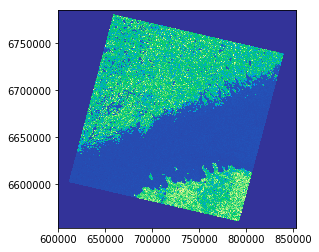

In [3]:
# Plot the data
show((data, 4), cmap='terrain')

In [4]:
# Now create a bounding box around the Helsinki region (WGS84 coordinates)
minx, miny = 24.60, 60.00
maxx, maxy = 25.22, 60.35
bbox = box(minx, miny, maxx, maxy)

# Insert into a new GeoDataFrame and reproject to raster geometry
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
geo = geo.to_crs(crs=data.crs.data)

In [5]:
# Rasterio wants coordinates in json format, so convertlike this
def get_features(gdf):
    """Function to parse features from GeoDataFrame into a list of json objects"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = get_features(geo)
print(coords)

[{'coordinates': [[[735275.3533476054, 6658919.843253607], [732783.5561207401, 6697846.086795722], [698608.1329965619, 6695816.080575279], [700733.5832412266, 6656875.248540204], [735275.3533476054, 6658919.843253607]]], 'type': 'Polygon'}]


In [6]:
# Now use the mask function of rasterio to clip the data
outData, outTransform = mask(raster=data, shapes=coords, crop=True)

# And copy the metadata from the original file
outMeta = data.meta.copy()
print(outMeta)

# And parse the EPSG value from the orginal CRS
epsgCode = int(data.crs.data['init'][5:])
print(epsgCode)

{'driver': 'GTiff', 'width': 8877, 'dtype': 'uint8', 'transform': (600466.5, 28.5, 0.0, 6784966.5, 0.0, -28.5), 'crs': CRS({'init': 'epsg:32634'}), 'nodata': None, 'count': 7, 'affine': Affine(28.5, 0.0, 600466.5,
       0.0, -28.5, 6784966.5), 'height': 8106}
32634


In [7]:
# Modify the metadate to reflect changes to the clipped data
outMeta.update({"driver": "GTiff",
                "height": outData.shape[1],
                "width": outData.shape[2],
                "transform": outTransform,
                "crs": pycrs.parser.from_epsg_code(epsgCode).to_proj4()})

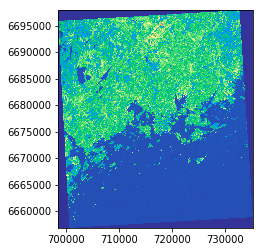

In [9]:
# Save the clipped data
outFile = "Data/Helsinki_clipped.tif"
with rasterio.open(outFile, "w", **outMeta) as FH:
    FH.write(outData)

# And plot
clipped = rasterio.open(outFile)
show((clipped, 5), cmap='terrain')